In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from utils import network_from_raw_data
from semi_metric_topology import create_synthetic_network, semi_metric_topology
from si_dynamics import get_si_results

# Synthetic network with tunable metric backbone and semi-metric distortion distribution from an empirical network

First thing, we'll do is get a sample empirical transportation network

In [2]:
city='Albany'
mobilitydef = network_from_raw_data(city)

Then we compute its semi-metric topology, i.e. identify the edges in the metric backbone and the semi-metric distortions of those not in the metric backbone

In [3]:
network = semi_metric_topology(mobilitydef) 
network.to_csv('Data/network_with_semi_metric_topology_%s.csv'%city,index=False)
network

,source,target,metric,proximity,s_value,distance,metric_distance
0,12007,12054,False,0.000161,17.607412,6218.0,353.146735
1,12007,12203,False,0.000056,43.986493,17728.0,403.032811
2,12007,12206,False,0.000094,25.699504,10657.0,414.677262
3,12007,12305,False,0.000103,20.393228,9671.0,474.226042
4,12007,12208,False,0.000052,49.883036,19158.0,384.058423
...,...,...,...,...,...,...,...
4617,12022,12040,False,0.006116,1.024294,162.5,158.645833
4618,12064,12076,False,0.004785,1.536643,208.0,135.360000
4619,12076,12131,False,0.005650,1.984366,176.0,88.693333
4620,12076,12194,False,0.010000,2.215095,99.0,44.693333


As you can see in the dataframe above, the edge from $12131$ to $12194$ is in the backbone (*metric* is $True$ and *s_value* is $1.0$).
In contrast, the edge from $12076$ to $12194$ is not in the backbone (*metric* is $False$ and *s_value* is $2.215$). In fact the measured distance between those nodes is $99$ while the shortest path length is $44.693$, a distortion $2.215$ times the shortest path length to the measured distance.

### Getting the metric backbone

In [4]:
metric_network = network[network['metric']==True]
G_metric=nx.from_pandas_edgelist(metric_network,source='source',target='target',edge_attr=['distance','proximity','metric_distance','s_value','metric'])

Once we have the metric backbone we can use it to compute the closure and afterwards generate a synthetic network.

In [6]:
tau=0.10 ## Relative size of the backbone
mu=1 ## Mean value of the lognormal distribution
sigma=1 ## Standard deviation
G_synthetic=create_synthetic_network(G_metric,G_closure,tau,mu,sigma) ## Networkx object with the synthetic network created
df_synthetic=nx.to_pandas_edgelist(G_synthetic) ## dataframe with the synthetic network


### Perform SI dynamics

In [7]:
network_name='Albany'
df_results=get_si_results(network_name)

Chi 0.00, Seed 12121 is done
Chi 0.00, Seed 12084 is done
Chi 0.00, Seed 12010 is done
Chi 0.00, Seed 12059 is done
Chi 0.00, Seed 12822 is done
Chi 0.00, Seed 12193 is done
Chi 0.00, Seed 12186 is done
Chi 0.00, Seed 12089 is done
Chi 0.00, Seed 12031 is done
Chi 0.00, Seed 12123 is done
Chi 0.05, Seed 12121 is done
Chi 0.05, Seed 12084 is done
Chi 0.05, Seed 12010 is done
Chi 0.05, Seed 12059 is done
Chi 0.05, Seed 12822 is done
Chi 0.05, Seed 12193 is done
Chi 0.05, Seed 12186 is done
Chi 0.05, Seed 12089 is done
Chi 0.05, Seed 12031 is done
Chi 0.05, Seed 12123 is done
Chi 0.10, Seed 12121 is done
Chi 0.10, Seed 12084 is done
Chi 0.10, Seed 12010 is done
Chi 0.10, Seed 12059 is done
Chi 0.10, Seed 12822 is done
Chi 0.10, Seed 12193 is done
Chi 0.10, Seed 12186 is done
Chi 0.10, Seed 12089 is done
Chi 0.10, Seed 12031 is done
Chi 0.10, Seed 12123 is done
Chi 0.15, Seed 12121 is done
Chi 0.15, Seed 12084 is done
Chi 0.15, Seed 12010 is done
Chi 0.15, Seed 12059 is done
Chi 0.15, Seed

In [8]:
df_results.to_csv('Data/si_dynamics_%s.csv'%city,index=False)

### Plot results of SDS

In [11]:
chi_values=np.arange(0.0,1.01,0.05)
network_names=['Albany']
results_ratio=pd.DataFrame()
for network in network_names:
    results=pd.DataFrame()
    for chi in chi_values:
        results_partial=df_results[df_results['size']==chi]
        results_partial['t_half']=[results_partial['times'].values[i][4] for i in range(len(results_partial))]## if obtaining results as a variable within the notebook
        #results_partial['t_half']=[results_partial['times'].values[i].split(',')[4] for i in range(len(results_partial))] ### if reading the results from a file
        results_partial['t_half']=results_partial['t_half'].astype(float)
        results_partial['seed']=results_partial['seed'].astype(int)
        #results_partial=results_partial.groupby(['seed','size','network','option'])['t_half'].mean().reset_index()
        results_partial=results_partial.groupby(['seed','size','network']).agg({'t_half':'median'}).reset_index() ## for each seed get the median of the distribution as the typical time for the disease to reach half of the population
        #results=results.append(results_partial)
        #### NOTE: UPDATED TO THE NEW PANDAS VERSION
        results=pd.concat([results, results_partial])
    results_original=results[results['size']==1]
    results_original=results_original.rename(columns={'t_half':'t_half_original'})
    results_original=results_original[['seed','t_half_original']]
    results_def=pd.merge(results,results_original,on=['seed'])
    results_def['ratio']=results_def['t_half']/results_def['t_half_original']
    results_def['size']=results_def['size'].astype(float)
    
    results_def=results_def.groupby(['size']).agg({'ratio':['mean','median','std']}).reset_index()
    count_linestyle=0
    
    results_def['network']=network.replace('_','/')
    #results_ratio=results_ratio.append(results_def)
    #### NOTE: UPDATED TO THE NEW PANDAS VERSION
    results_ratio=pd.concat([results_ratio, results_def])
results_ratio.columns=results_ratio.columns.to_flat_index()
results_ratio.columns=['size','ratio_mean','ratio_median','ratio_std','network']

C:\Users\Felipe Xavier Costa\AppData\Local\Temp\ipykernel_20584\1787028088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_partial['t_half']=[results_partial['times'].values[i][4] for i in range(len(results_partial))]## if obtaining results as a variable within the notebook
C:\Users\Felipe Xavier Costa\AppData\Local\Temp\ipykernel_20584\1787028088.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_partial['t_half']=results_partial['t_half'].astype(float)
C:\Users\Felipe Xavier Costa\Ap

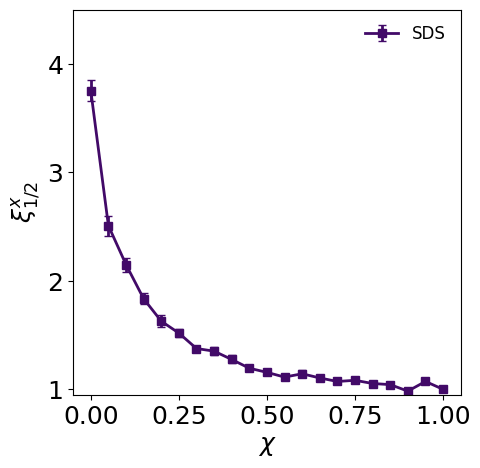

In [18]:
linestyle={'s_value':'solid'}
colors={}
labels={'s_value':'SDS'}
colors_n=plt.cm.inferno([0.2])
for i in range(len(colors_n)):
    colors[list(linestyle.keys())[i]]=colors_n[i]
fig,ax=plt.subplots(1,1,figsize=(5,5))
results_ratio['ratio_std']=results_ratio['ratio_std'].astype(float)
results_ratio['ratio_mean']=results_ratio['ratio_mean'].astype(float)
ax.errorbar(results_ratio['size'],results_ratio['ratio_mean'],yerr=results_ratio['ratio_std'].astype(float)/np.sqrt(30),lw=2,color=colors['s_value'],label=labels['s_value'],marker='s',capsize=3,elinewidth=2)
ax.tick_params(which='major',axis='both',labelsize=18) 
ax.set_xlabel(r'$\chi$',fontsize=18)
ax.set_ylabel(r'$\xi_{1/2}^{x}$',fontsize=18)
#ax.set_title(network.replace('_','/'),fontsize=14)
ax.legend(frameon=False,fontsize=12)

ax.set_ylim(0.95,4.5)
#ax.text(0.05,1.10, 'a)', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
plt.show()
